# Model 1, YOLO v5
Ximena Vazquez Mellado Flores 171319

##First step, get model.
In this step, the model was obtained cloning a GitHub repository, then the installation of the needed requirements located in `requirements.txt`.

The repository is located [here](https://github.com/ultralytics/yolov5)

##Rationale of the selection

The choice of YOLOv5 for our project is driven by its strengths in real-time object detection, efficiency, and ease of integration. YOLOv5, or "You Only Look Once," is renowned for its single-shot detection approach, where the entire image is processed in one forward pass, enabling rapid and simultaneous identification of multiple objects. This characteristic is crucial for our goal of real-time identification and tracking of big cats in video streams.

The YOLOv5 architecture is lightweight, making it computationally efficient without compromising on accuracy. This efficiency is particularly advantageous for deployment in real-time applications, ensuring timely and responsive processing of video data. Moreover, YOLOv5's versatility allows for seamless integration of both object detection and classification tasks, streamlining the identification process for different big cat species.

In [1]:
# clone YOLOv5 repository
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
!git reset --hard 064365d8683fd002e9ad789c1e91fa3d021b44f0

Cloning into 'yolov5'...
remote: Enumerating objects: 16074, done.
remote: Counting objects: 100% (18/18), done.
remote: Compressing objects: 100% (17/17), done.
remote: Total 16074 (delta 5), reused 5 (delta 1), pack-reused 16056
Receiving objects: 100% (16074/16074), 14.71 MiB | 15.35 MiB/s, done.
Resolving deltas: 100% (11037/11037), done.
/content/yolov5
HEAD is now at 064365d Update parse_opt() in export.py to work as in train.py (#10789)


In [2]:
# install dependencies as necessary
!pip install -qr requirements.txt  # install dependencies (ignore errors)
import torch

from IPython.display import Image, clear_output  # to display images
from utils.downloads import attempt_download  # to download models/datasets

# clear_output()
print('Setup complete. Using torch %s %s' % (torch.__version__, torch.cuda.get_device_properties(0) if torch.cuda.is_available() else 'CPU'))

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.6/190.6 kB 3.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 32.1 MB/s eta 0:00:00
Setup complete. Using torch 2.1.0+cu118 CPU


##Next step, get the needed data

For this assignment, the "Big Cats" dataset was used from roboflow. This dataset can be found [here](https://universe.roboflow.com/ds/4P06Jv8ugF?key=SNHxb7etDI)

An example of the dataset can be seen in the following image:

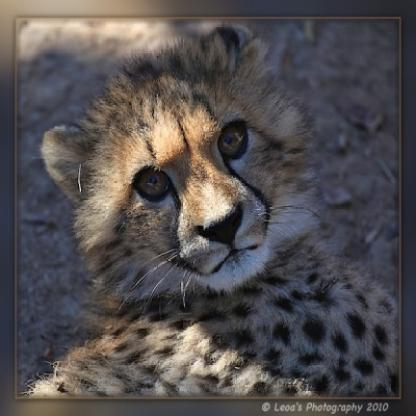

This dataset is divided into three different and useful folders:
- Train
- Test
- Validation

The data is extracted from the roblow library and authenticates it with the Roboflow API using an API key.

In [3]:
!pip install -q roboflow

from roboflow import Roboflow
rf = Roboflow(api_key="NmQ5F99x87ywz3BpJ1JB")
project = rf.workspace("xyz-mithp").project("big-cats")
dataset = project.version(1).download("yolov5")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 kB 1.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.8/58.8 kB 5.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.1/49.1 MB 15.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.8/67.8 kB 8.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.2/72.2 kB 8.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 6.7 MB/s eta 0:00:00
loading Roboflow workspace...
loading Roboflow project...



Extracting Dataset Version Zip to BIG-CATS-1 in yolov5pytorch:: 100%|██████████| 7200/7200 [00:01<00:00, 6284.27it/s]


In [4]:
%cd /content/yolov5

/content/yolov5


## Thirdly, create the custom dataset YAML file

We write a `YAML` script that defines the parameters for our model like the number of classes, anchors, and each layer.

This YAML configuration file (`custom_yolov5s.yaml`) is used as input when training the YOLOv5 model, defining its structure, hyperparameters, and other important settings.

In [6]:
# define number of classes based on YAML
import yaml
with open(dataset.location + "/data.yaml", 'r') as stream:
    num_classes = str(yaml.safe_load(stream)['nc'])

In [7]:
#customize iPython writefile so we can write variables
from IPython.core.magic import register_line_cell_magic

@register_line_cell_magic
def writetemplate(line, cell):
    with open(line, 'w') as f:
        f.write(cell.format(**globals()))

In [8]:
%%writetemplate /content/yolov5/models/custom_yolov5s.yaml

# parameters
nc: {num_classes}  # number of classes
depth_multiple: 0.33  # model depth multiple
width_multiple: 0.50  # layer channel multiple

# anchors
anchors:
  - [10,13, 16,30, 33,23]  # P3/8
  - [30,61, 62,45, 59,119]  # P4/16
  - [116,90, 156,198, 373,326]  # P5/32

# YOLOv5 backbone
backbone:
  # [from, number, module, args]
  [[-1, 1, Focus, [64, 3]],  # 0-P1/2
   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4
   [-1, 3, BottleneckCSP, [128]],
   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8
   [-1, 9, BottleneckCSP, [256]],
   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16
   [-1, 9, BottleneckCSP, [512]],
   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32
   [-1, 1, SPP, [1024, [5, 9, 13]]],
   [-1, 3, BottleneckCSP, [1024, False]],  # 9
  ]

# YOLOv5 head
head:
  [[-1, 1, Conv, [512, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 6], 1, Concat, [1]],  # cat backbone P4
   [-1, 3, BottleneckCSP, [512, False]],  # 13

   [-1, 1, Conv, [256, 1, 1]],
   [-1, 1, nn.Upsample, [None, 2, 'nearest']],
   [[-1, 4], 1, Concat, [1]],  # cat backbone P3
   [-1, 3, BottleneckCSP, [256, False]],  # 17 (P3/8-small)

   [-1, 1, Conv, [256, 3, 2]],
   [[-1, 14], 1, Concat, [1]],  # cat head P4
   [-1, 3, BottleneckCSP, [512, False]],  # 20 (P4/16-medium)

   [-1, 1, Conv, [512, 3, 2]],
   [[-1, 10], 1, Concat, [1]],  # cat head P5
   [-1, 3, BottleneckCSP, [1024, False]],  # 23 (P5/32-large)

   [[17, 20, 23], 1, Detect, [nc, anchors]],  # Detect(P3, P4, P5)
  ]

## Training the new custom YOLOv5 Detector

Here, we are able to pass a number of arguments, and some examples are:
- **img:** define input image size
- **batch:** determine batch size
- **epochs:** define the number of training epochs.
- **data:** set the path to our yaml file
- **cfg:** specify our model configuration
- **weights:** specify a custom path to weights.
- **nosave:** only save the final checkpoint
- **cache:** cache images for faster training

This model was trained with 20 epochs, batches of 18 images, and using the `custom_yolov5s.yaml` file written in the previous step.

In [10]:
%%time
%cd /content/yolov5/
!python train.py --img 416 --batch 18 --epochs 20 --data {dataset.location}/data.yaml --cfg ./models/custom_yolov5s.yaml --weights '' --name yolov5s_results  --cache

/content/yolov5
2023-11-21 00:51:17.782867: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-21 00:51:17.782948: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-21 00:51:17.783010: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-21 00:51:19.183002: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
train: weights=, cfg=./models/custom_yolov5s.yaml, data=/content/yolov5/BIG-CATS-1/data.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=20, batch_size=18, imgsz=416, rect=False, resume=False, nosave=False, noval=False, no

## Fifth, evaluate Custom YOLOv5 Detector Performance

We can view the training graphs associated with a training job in the `/content/yolov5/runs/train/yolov5s_results/results.png` folder.

Training losses and performance metrics are also saved to Tensorboard and also to a logfile defined above with the **--name** flag when we train. In our case, we named this `yolov5s_results`.


In [13]:
%cd /content/yolov5/
!python val.py --data {dataset.location}/data.yaml --weights '/content/drive/MyDrive/Artificial Vision/project2/yolov5_weights/yolov5_best.pt'

/content/yolov5
val: data=/content/yolov5/BIG-CATS-1/data.yaml, weights=['/content/drive/MyDrive/Artificial Vision/project2/yolov5_weights/yolov5_best.pt'], batch_size=32, imgsz=640, conf_thres=0.001, iou_thres=0.6, max_det=300, task=val, device=, workers=8, single_cls=False, augment=False, verbose=False, save_txt=False, save_hybrid=False, save_conf=False, save_json=False, project=runs/val, name=exp, exist_ok=False, half=False, dnn=False
YOLOv5 🚀 v7.0-72-g064365d Python-3.10.12 torch-2.1.0+cu118 CPU

Fusing layers... 
custom_YOLOv5s summary: 182 layers, 7251912 parameters, 0 gradients
val: Scanning /content/yolov5/BIG-CATS-1/valid/labels.cache... 299 images, 0 backgrounds, 0 corrupt: 100% 299/299 [00:00<?, ?it/s]
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100% 10/10 [03:54<00:00, 23.43s/it]
                   all        299        303      0.367      0.299      0.203     0.0406
               Cheetah        299         97      0.409      0

# Finally, run inference with out trained weights

Next, we can run inference with our new model's weights in our big cats video.

In [11]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
%cd /content/yolov5/
!python detect.py --weights '/content/drive/MyDrive/Artificial Vision/project2/yolov5_weights/yolov5_best.pt' --source '/content/drive/MyDrive/Artificial Vision/project2/BIG CATS.mp4'